### Plotting velocity vs angle in a circular plot from ilastik tracking csv

Starting from a tracking csv export results for a 2d time series, we will look how fast objects move from frame to frame.

velocity (from frame to frame) is caluclated with the following formula:
$\text{velocity} = \frac{\text{distance}}{\text{time}} = \frac{\sqrt{d_x^2 + d_y^2}}{d_t}$, where $d_x$ is the change in position along the $x$-axis, $d_y$ the change in position along the $y$-axis and $d_t$ the time between frames.

For this, we will
* convert coordinates (centers of the objects, with $x$ coordinate `Center_of_the_object_0`, and $y$ coordinate `Center_of_the_object_1`) from image coordinates (as exported from ilastik) to world coordinates,
* link objects between time frames using the `trackId`,
* calculate velocity, and direction (relative to the image axes)
* plot angle vs velocity in a circular plot.

In [1]:
from matplotlib import pyplot as plt
import pandas
import numpy

In [2]:
# change this path to your exported tracking .csv file
csv_file_path = "example_data/mitocheck_94570_2D+t_01-53_CSV-Table.h5.csv"
# Configuration, please fill in meta data
# The units here will determine the result (pixel_size_x and pixel_size_y have to be the same units)
# if you put in the sizes in terms of milimeters and the time in terms of seconds, the velocity will be
# milimeters per seconds...
# Unfortunately I don't know the values for the data used to produce the table, will assume
# 0.2 um for pixel size, and 0.5 hours for time
meta_data = {
    "pixel_size_x": 0.2,  # how large is a pixel?
    "pixel_size_y": 0.2,  # usually the same as x, but who knows...
    "time_between_frames": 0.5,
}

In [3]:
# read data
df = pandas.read_csv(csv_file_path)
# discard "false detections" (denoted by trackId -1) are excluded immediatelly
df = df[df["trackId"]!=-1]

In [4]:
# tracks link objects across time frames, so we sort first by trackId and then by frame.
# an object (track) will then be in consecutive rows in the dataframe
df = df.sort_values(["trackId", "frame"])
df = df.set_index(["trackId", "frame"])

In [5]:
# convert to "world" coordinates.
# We assume here a "rigid" transformation, and also discard any translation
# as it will not change speed/angle
# so in effect, we only apply scaling here :)
df["pos_x"] = meta_data["pixel_size_x"] * df["Center_of_the_object_0"]
df["pos_y"] = meta_data["pixel_size_y"] * df["Center_of_the_object_1"]

In [6]:
# calculate the difference between consecutive time frames of the same trackId
# this difference is zero in the time frame of the first "appearance" of each trackId
df["dx"] = df.groupby("trackId")["pos_x"].diff()
df["dy"] = df.groupby("trackId")["pos_y"].diff()

In [7]:
# calculate the length of the vector (dx, dy) and devide it by the time
df["velocity"] = df.apply(lambda x: numpy.linalg.norm([x["dx"], x["dy"]]) / meta_data["time_between_frames"], axis=1)
# also calculate angle using the differences
df["angle"] = df.apply(lambda x: numpy.arctan2(x["dx"], x["dy"]), axis=1)

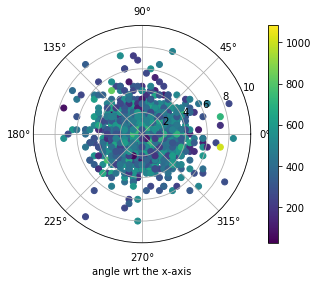

In [8]:
# now do the plotting
f = plt.figure()
s = f.add_subplot(111, polar=True)
# we use a scatterplot in a polar coordinate system here
# the angle theta is given first, then the "radius" (in our case that's the velocity)
# c=... indicates coloring - any numerical value can be used, e.g. df["Size_in_pixels_0"] to indicate size. 
sc = s.scatter(df["angle"].values, df["velocity"].values, c=df["Size_in_pixels_0"].values)
s.set_xlabel("angle wrt the x-axis")
# I choose to only show velocities between 0 and 10 um/hour
s.set_ylim([0, 10])
f.colorbar(sc)